## Data Density and Distribution

This notebook looks at the data density of MEOP data set and the temporal and spatial distribution of the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import pdb
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import xarray as xr
import cartopy.crs as ccrs

<IPython.core.display.Javascript object>


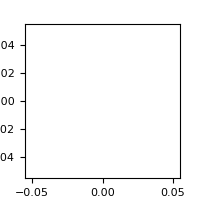

In [412]:
%matplotlib notebook
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

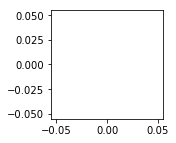

In [431]:
%matplotlib inline
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

In [2]:
dfmg = pd.read_csv("dfmg_corrected_DIST_IS_GL.csv")
dfgamma = pd.read_csv("gamman.csv", names=['PROFILE_NUMBER', 'gamman'])
dfmg['gamman'] = dfgamma['gamman']
del dfmg['Unnamed: 0']
dfmg.loc[:,'JULD'] = pd.to_datetime(dfmg.loc[:, 'JULD'])
dfmg.loc[(dfmg['gamman'] < 0), "gamman"] = np.nan

In [3]:
dfmg["DIST_min"] = dfmg.loc[:, ["DIST_GLINE", "DIST_ISE"]].min(axis=1)

In [4]:
import plot_stations as pltStn
import importlib
importlib.reload(pltStn)

import plot_bathy as pltBathy
import importlib
importlib.reload(pltBathy)

import find_depth_averages_v2 as averageProfile
import plot_var_contours_with_distance as plt2dDepthVsDist

import plot_station_bot_sal as pbs

import plot_topView_contourf as topView
importlib.reload(topView)

import plot_monthly_count as monthCount
importlib.reload(monthCount)

import plot_surfbot_vsTime as pltsurfbot

import plot_profiles_vs_dist as profDist

In [5]:
sel_sal35 = (dfmg.PSAL_ADJUSTED > 35) #& (dfmg.LONGITUDE > 150)
sel_tags = dfmg.PLATFORM_NUMBER.isin(dfmg.loc[sel_sal35, "PLATFORM_NUMBER"].unique())
dfmg = dfmg.loc[~sel_tags]

In [6]:
WSO_source = (dfmg['CTEMP'] <= -1.7 ) & (dfmg["PSAL_ADJUSTED"] > 34.5)
WSO_prod = (dfmg['CTEMP'] <= -0.8) & (dfmg['CTEMP'] >= -1.2) & (dfmg["PSAL_ADJUSTED"] > 34.5)

box1 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box2 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)
box3 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box4 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)

box5 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box6 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)
box7 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box8 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)

box9 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 60) & (dfmg["LONGITUDE"] < 70)
box10 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 82)

Weddell = (box1 | box2 | box3| box4)
Ross = (box5 | box6 | box7 | box8) & (dfmg.LATITUDE < -72.5)
Prydz = box10
EBS = (dfmg['LONGITUDE'] > -80) & (dfmg['LONGITUDE'] < -60) #Eastern Bellingshausen Sea
WBS = (dfmg['LONGITUDE'] > -100) & (dfmg['LONGITUDE'] < -80) # Western Bellingshausen Sea
BS = (EBS + WBS)
Adelie = (dfmg['LONGITUDE'] > 135) & (dfmg['LONGITUDE'] < 145) # Adelie Coast
Knox = (dfmg['LONGITUDE'] > 101) & (dfmg['LONGITUDE'] < 112) 
PrincessMartha = (dfmg['LONGITUDE'] > -20) & (dfmg['LONGITUDE'] < 0) & (dfmg.LATITUDE <= -65)
CDP = box9
WPB = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 75)
EPB = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 75) & (dfmg["LONGITUDE"] <= 82)
AmundsenEast = (dfmg.LONGITUDE <= -100) & (dfmg.LONGITUDE >= -110) & (dfmg.LATITUDE <= -70)
AmundsenWest = (dfmg.LONGITUDE <= -110) & (dfmg.LONGITUDE >= -120) & (dfmg.LATITUDE <= -70)
Amundsen = AmundsenEast + AmundsenWest
AS = (AmundsenEast + AmundsenWest)
LAC = (dfmg.LONGITUDE > 82) & (dfmg.LONGITUDE <= 87) & (dfmg.LATITUDE <= -65)# Leopold and Astrid Coast
QMC = (dfmg.LONGITUDE > 87) & (dfmg.LONGITUDE <= 96.5) & (dfmg.LATITUDE <= -65)# Wilhelm II Coast and Queen Mary Coast
Harald = (dfmg.LONGITUDE >= 29) & (dfmg.LONGITUDE <= 37) & (dfmg.LATITUDE <= -65)# Harald Coast

lowSurfSal = (dfmg['PSAL_ADJUSTED'] < 33.5) & (dfmg['DEPTH'] > -100)
ASW = (dfmg.CTEMP > -1.5) & (dfmg.PRES_ADJUSTED < 150) & (dfmg.POT_DENSITY < 27.4)
surfaceWaters = dfmg.PRES_ADJUSTED < 100

cdw = (dfmg['PSAL_ADJUSTED'] > 34.6) & (dfmg['CTEMP'] > 0)
maxTemp = (dfmg.groupby('PROFILE_NUMBER')['CTEMP'].transform(max) == dfmg['CTEMP'])
gline_le_50km = dfmg['DIST_min'] <= 50
gline_le_100km = dfmg['DIST_min'] <= 100
gline_le_150km = dfmg['DIST_min'] <= 150
gline_le_25km = dfmg['DIST_min'] <= 25
gline_le_75km = dfmg['DIST_min'] <= 75

sel_echodepth = dfmg.ECHODEPTH > -3000

mask_theta_sal_not_nan = ~(dfmg.loc[:, 'CTEMP'].isnull() + dfmg.loc[:, 'PSAL_ADJUSTED'].isnull())

deepMask250 = dfmg.DEPTH <= -250
deepMask375 = dfmg.DEPTH <= -375
deepMask500 = dfmg.DEPTH <= -500

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [7]:
year_mask = []
years_df = np.sort(dfmg['JULD'].dt.year.unique())
for i in range(len(years_df)):
    mask = dfmg['JULD'].dt.year == years_df[i]
    year_mask.append(mask)
month_mask = []
for i in range(12):
    mask = dfmg['JULD'].dt.month == i+1
    month_mask.append(mask)
    
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [8]:
def sel_months(df, months=[1]):
    return df['JULD'].dt.month.isin(months)

def get_mask_from_prof_mask(df, profmask):
    profs = dfmg.loc[profmask, 'PROFILE_NUMBER'].unique()
    mask = dfmg.loc[:, 'PROFILE_NUMBER'].isin(profs)
    
    return mask

def play_beep():
    import os
    duration = 1  # second
    freq = 440  # Hz
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

In [9]:
DSW = (dfmg.gamman > 28.27) & (dfmg.PSAL_ADJUSTED > 34.5) & (dfmg.CTEMP <= -1.8) & (dfmg.CTEMP >= -1.9)
lssw = (dfmg.PSAL_ADJUSTED >= 34.3) & (dfmg.PSAL_ADJUSTED <= 34.4) & (dfmg.CTEMP <= -1.5) & (dfmg.CTEMP > -1.9)
ISW = (dfmg.CTEMP < -1.9)

CDW = (dfmg.CTEMP >= 0) & (dfmg.PSAL_ADJUSTED >= 34.5)
mCDW = (dfmg.CTEMP < 0) & (dfmg.CTEMP > -1.8) & (dfmg.gamman > 28) & (dfmg.gamman < 28.27)

In [23]:
years_df

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018])

In [443]:
def plotDataDensities(region_name, years, region_mask):
    for i in range(len(years)):
        yind = np.argmin(np.abs(years_df - years[i]))
        mask = region_mask & year_mask[yind]
        levels = [1,5,10,20,30,50,100,200]
        topView.plotDataDensity(dfmg[mask], levels=levels, region=region_name,save=True, 
                                savename='./Images/dataDensity/'+str(region_name)+str(years[i])+'.png', show=True)

In [10]:
bathy = xr.open_dataset('/media/data/Datasets/Bathymetry/GEBCO_2014_2D.nc')

In [211]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

In [40]:
190/25.4

7.480314960629921

In [41]:
230 / 25.4

9.05511811023622

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:278: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Xgrid = np.linspace(m.llcrnrx, m.urcrnrx, nx)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:279: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Ygrid = np.linspace(m.llcrnry, m.urcrnry, ny)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3572: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/base

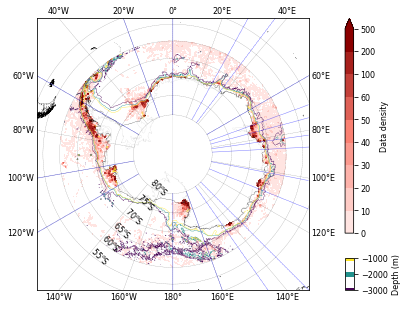

In [26]:
var = 'PSAL_ADJUSTED'
dfno = dfmg.loc[~dfmg.loc[:, var].isnull()]
levels = [0, 10, 20, 30, 40, 50, 60, 100, 200, 500] #, 90, 150, 250, 500, 1000, 2500]
topView.plotDataDensity(dfno, wd=190/25.4, ht=230*0.5/25.4, levels=levels, cx=20, cy=20,
                        save=True, savename="./Images/dataDensity/dataDensity.pdf", show=True, plotBathy=True, 
                        fontsize=8)

In [20]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

In [11]:
import os
import fiona
import shapely.geometry as sgeom
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import matplotlib.gridspec as gridspec 

In [12]:
DATADIR = os.path.join("/media/data/")

In [14]:
bathyS = xr.open_dataset("/media/hdd2/SOSE_1_12/bathyS.nc")

<IPython.core.display.Javascript object>


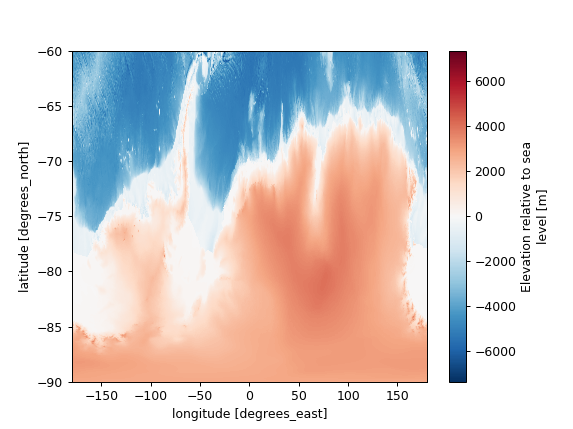

In [66]:
bathyS.elevation.plot()

In [14]:
summer_months = [12] + list(np.arange(1,6,1))
winter_months = list(np.arange(6, 12, 1))
print(summer_months, winter_months)

[12, 1, 2, 3, 4, 5] [6, 7, 8, 9, 10, 11]


In [15]:
def plot_NIS_DIS_profiles(df, regions, mrows=4, ncols=3, months=list(np.arange(1,13,1)), 
                          wd=190/25.4, ht=210/25.4):
    DATADIR = "/media/data"
    plt.close(1)
    plt.figure(1, figsize=(wd, ht))

    gs = gridspec.GridSpec(mrows, ncols, height_ratios=[1]*mrows, width_ratios=[1]*ncols)
    counter = 0
    color_region = ['b', 'r']
    NIS = gline_le_50km
    DIS = ~gline_le_50km
    summer_months = [12]+list(np.arange(1,6,1))
    winter_months = list(np.arange(6,12,1))
    area_sel = [NIS, DIS]
    lonlatlims = [-180, 180, -90, -60]

    shpfile = DATADIR+"/Datasets/Shapefiles/AntarcticGroundingLine/GSHHS_f_L6.shp"
    with fiona.open(shpfile) as records:
        geometries = [sgeom.shape(shp['geometry']) for shp in records]
    ISedgefname = DATADIR+"/Datasets/Shapefiles/AntIceShelfEdge/ne_10m_antarctic_ice_shelves_lines.shp"
    ISe_feature = ShapelyFeature(Reader(ISedgefname).geometries(), ccrs.PlateCarree(), facecolor='none', 
                                         edgecolor="k")
    mapax = []
    for i in range(0,3,2):
        for j in range(ncols):
            mapax.append(plt.subplot(gs[i, j], projection = ccrs.PlateCarree()) )
            for r in range(2):
                dfsel = df.JULD.dt.month.isin(summer_months) & regions[counter] & area_sel[r]
            
                lons, lats = df[dfsel].drop_duplicates(['LATITUDE', 'LONGITUDE']).LONGITUDE.values, \
                             df[dfsel].drop_duplicates(['LATITUDE', 'LONGITUDE']).LATITUDE.values
                mapax[-1].scatter(lons, lats, color=color_region[r], marker="o", 
                                  transform= ccrs.PlateCarree())

            mapax[-1].add_geometries(geometries, ccrs.PlateCarree(), edgecolor='gray', facecolor='none')
            mapax[-1].add_feature(ISe_feature, zorder=3)

            #lonlatlims[0], lonlatlims[1] = df[dfsel].LONGITUDE.min() - 10 , df[dfsel].LONGITUDE.max()+10
            
            #mapax[-1].set_xlim(lonlatlims[0], lonlatlims[1])
            #mapax[-1].set_ylim(lonlatlims[2], lonlatlims[3])

            mapax[-1].contour(bathyS.lon, bathyS.lat, bathyS.elevation, levels=[-1000], colors="magenta")


            mapax.append(plt.subplot(gs[i+1, j] , projection = ccrs.PlateCarree()))
            for r in range(2):
                dfsel = df.JULD.dt.month.isin(winter_months) & regions[counter] & area_sel[r]
            
                lons, lats = df[dfsel].drop_duplicates(['LATITUDE', 'LONGITUDE']).LONGITUDE.values, \
                             df[dfsel].drop_duplicates(['LATITUDE', 'LONGITUDE']).LATITUDE.values
                mapax[-1].scatter(lons, lats, color=color_region[r], marker="o", transform= ccrs.PlateCarree())
            mapax[-1].add_geometries(geometries, ccrs.PlateCarree(), edgecolor='gray', facecolor='none')
            mapax[-1].add_feature(ISe_feature, zorder=3)
            #mapax[-1].set_xlim(lonlatlims[0], lonlatlims[1])
            #mapax[-1].set_ylim(lonlatlims[2], lonlatlims[3])

            mapax[-1].contour(bathyS.lon, bathyS.lat, bathyS.elevation, levels=[-1000], colors="magenta")
            
            print(counter)
            counter += 1


In [16]:
lonlatlims = [[-50, -15, -85, -65]]

In [386]:
dfsel = Weddell & dfmg.JULD.dt.month.isin(summer_months) & gline_le_50km
sel_inds  = dfmg[dfsel].groupby("PROFILE_NUMBER").head(1).index
lons, lats = dfmg.loc[sel_inds, "LONGITUDE"].values, dfmg.loc[sel_inds, "LATITUDE"].values


In [387]:
len(dfmg.loc[gline_le_25km])

835701

In [17]:
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [18]:
def plot_NIS_DIS_profiles_single(df, regions, months=list(np.arange(1,13,1)), central_longitude=0,
                          wd=190/25.4, ht=210/25.4):
    DATADIR = "/media/data"
    plt.close(1)
    plt.figure(1, figsize=(wd, ht))

    

    shpfile = DATADIR+"/Datasets/Shapefiles/AntarcticGroundingLine/GSHHS_f_L6.shp"
    with fiona.open(shpfile) as records:
        geometries = [sgeom.shape(shp['geometry']) for shp in records]
    ISedgefname = DATADIR+"/Datasets/Shapefiles/AntIceShelf/ne_10m_antarctic_ice_shelves_polys.shp"
    ISe_feature = ShapelyFeature(Reader(ISedgefname).geometries(), 
                                 ccrs.PlateCarree(), linewidth=0.5,
                                 facecolor='none', 
                                 edgecolor="k")
    
    mapax = plt.subplot(projection = ccrs.Orthographic(central_longitude=central_longitude, 
                                                       central_latitude=-90))
    
    for r in range(1):
        dfsel = df.JULD.dt.month.isin(months) & regions
        sel_inds = dfmg[dfsel].groupby("PROFILE_NUMBER").head(1).index
        lons, lats = dfmg.loc[sel_inds, "LONGITUDE"].values, dfmg.loc[sel_inds, "LATITUDE"].values
        print("Regions", np.min(lons), np.max(lons), np.min(lats), np.max(lats))
        mapax.scatter(lons, lats, color=color_region[r], marker=".", transform= ccrs.PlateCarree())

    mapax.add_geometries(geometries, ccrs.PlateCarree(), edgecolor='0.9', facecolor='0.7',alpha=0.5)
    mapax.add_feature(ISe_feature, zorder=3)

    
    #mapax.set_xlim(lonlatlims[0], lonlatlims[1])
    #mapax.set_ylim(lonlatlims[2], lonlatlims[3])
    
    mapax.contour(bathyS.lon, bathyS.lat, bathyS.elevation, levels=[-1000], colors="magenta",
                  transform= ccrs.PlateCarree())
    
    gl = mapax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=0.5, color='gray', alpha=1, linestyle='--')
    
    #gl = mapax.gridlines()
    
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(-80, -59, 5))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

<IPython.core.display.Javascript object>


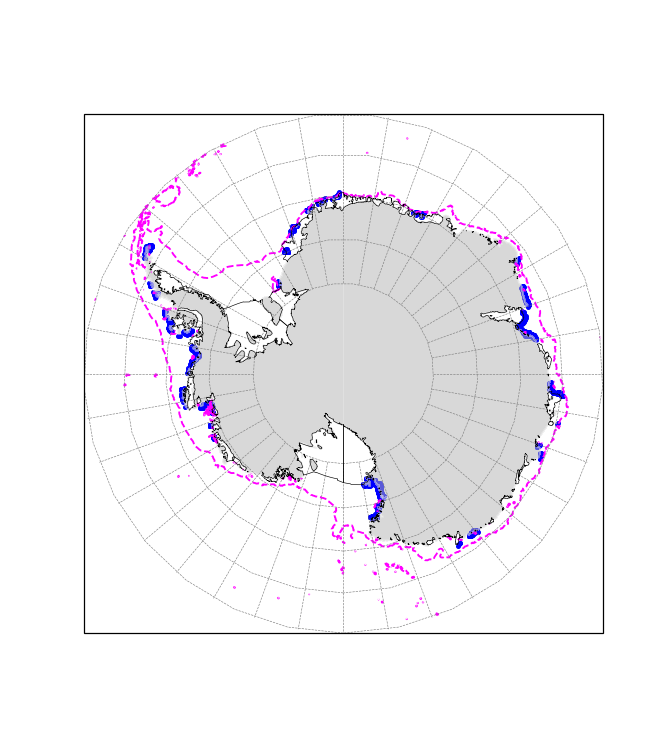

Regions -117.01804102781271 169.9056 -78.06 -63.0978


In [199]:
plot_NIS_DIS_profiles_single(dfmg, [True]*len(dfmg), months= [12,1,2],
                            central_longitude=0)

In [47]:
from matplotlib.colorbar import Colorbar

In [45]:
regions = Weddell + PrincessMartha + Harald + CDP + WPB + EPB + LAC + Knox + Adelie + Ross + Amundsen + BS

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


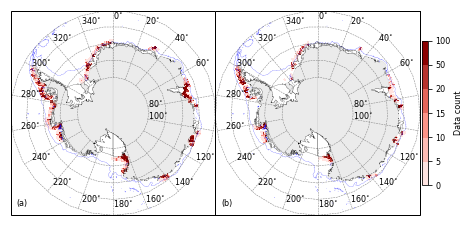

In [50]:
wd, ht = 190/25.4, 230*0.5/25.4
plt.figure(1, figsize=(wd,ht));
gs = gridspec.GridSpec(5, 4, height_ratios=[1]*5, width_ratios=[1, 1, 0.01, 0.03], wspace=0.)

mapax = plt.subplot(gs[:,0], projection = ccrs.Orthographic(central_longitude=0, central_latitude=-90) )
dfsel = ~dfmg.CTEMP.isna() & gline_le_75km & sel_months(dfmg, [12,1,2,3,4,5]) & sel_echodepth & regions

levels = list(np.arange(0,20.1, 5)) + [50, 100]
CF1 = topView.plotDataDensity_NIS_DIS(dfmg[dfsel], dfmg[~dfsel], wd=5.8, ht = 5, levels=levels, save=False,
                               savename = "./Images/dataDensity/NIS_summer.jpg", mapax=mapax, subplotlabel="(a)",
                                     dx=0.5, dy=0.5)

mapax2 = plt.subplot(gs[:,1], projection = ccrs.Orthographic(central_longitude=0, central_latitude=-90) )
dfsel = ~dfmg.CTEMP.isna() & gline_le_75km & sel_months(dfmg, [6,7,8,9,10,11]) & sel_echodepth & regions
CF2 = topView.plotDataDensity_NIS_DIS(dfmg[dfsel], dfmg[~dfsel], wd=5.8, ht = 5, levels=levels, save=False,
                               savename = "./Images/dataDensity/NIS_winter.jpg", mapax=mapax2, subplotlabel="(b)",
                                     dx=0.5, dy=0.5)

colorbarax = plt.subplot(gs[1:4, 3])
cbar1 = Colorbar(ax = colorbarax, mappable = CF1, ticks=levels, orientation='vertical') 
cbar1.ax.set_ylabel("Data count")
plt.savefig("./Images/dataDensity/NIS_summer_winter_360.pdf", dpi=600, bbox_inches = "tight")
plt.show()

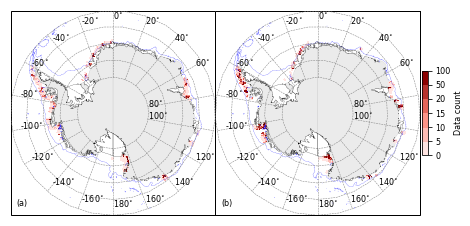

In [33]:
wd, ht = 190/25.4, 230/25.4
plt.figure(1, figsize=(wd,ht));
gs = gridspec.GridSpec(5, 4, height_ratios=[1]*5, width_ratios=[1, 1, 0.01, 0.03], wspace=0.)

mapax = plt.subplot(gs[:,0], projection = ccrs.Orthographic(central_longitude=0, central_latitude=-90) )
dfsel = ~dfmg.CTEMP.isna() & gline_le_75km & sel_months(dfmg, [12,1,2]) & sel_echodepth & regions

levels = list(np.arange(0,20.1, 5)) + [50, 100]

CF1 = topView.plotDataDensity_NIS_DIS(dfmg[dfsel], dfmg[~dfsel], wd=5.8, ht = 5, levels=levels, save=False,
                               savename = "./Images/dataDensity/NIS_DJF.jpg", mapax=mapax, subplotlabel="(a)",
                                     dx=0.5, dy=0.5)

mapax2 = plt.subplot(gs[:,1], projection = ccrs.Orthographic(central_longitude=0, central_latitude=-90) )
dfsel = ~dfmg.CTEMP.isna() & gline_le_75km & sel_months(dfmg, [7,8,9]) & sel_echodepth & regions
CF2 = topView.plotDataDensity_NIS_DIS(dfmg[dfsel], dfmg[~dfsel], wd=5.8, ht = 5, levels=levels, save=False,
                               savename = "./Images/dataDensity/NIS_JAS.jpg", mapax=mapax2, subplotlabel="(b)",
                                     dx=0.5, dy=0.5)

colorbarax = plt.subplot(gs[2, 3])
cbar1 = Colorbar(ax = colorbarax, mappable = CF1, ticks=levels, orientation='vertical') 
cbar1.ax.set_ylabel("Data count")
plt.savefig("./Images/dataDensity/NIS_DJF_JAS.jpg", dpi=600, bbox_inches = "tight")
plt.show()

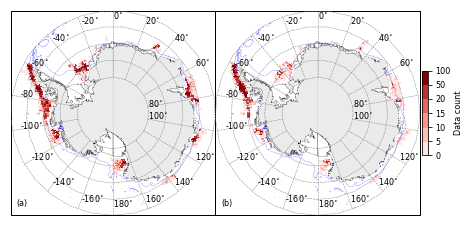

In [34]:
wd, ht = 190/25.4, 230/25.4
plt.figure(1, figsize=(wd,ht));
gs = gridspec.GridSpec(5, 4, height_ratios=[1]*5, width_ratios=[1, 1, 0.01, 0.03], wspace=0.)

mapax = plt.subplot(gs[:,0], projection = ccrs.Orthographic(central_longitude=0, central_latitude=-90) )
dfsel = ~dfmg.CTEMP.isna() & ~gline_le_75km & sel_months(dfmg, [12,1,2,3,4,5]) & regions & sel_echodepth
levels = list(np.arange(0,20.1, 5)) + [50, 100]
CF1 = topView.plotDataDensity_NIS_DIS(dfmg[dfsel], dfmg[~dfsel], wd=5.8, ht = 5, levels=levels, save=False,
                               mapax=mapax, subplotlabel="(a)", dx=0.5, dy=0.5)

mapax2 = plt.subplot(gs[:,1], projection = ccrs.Orthographic(central_longitude=0, central_latitude=-90) )
dfsel = ~dfmg.CTEMP.isna() & ~gline_le_75km & sel_months(dfmg, [6,7,8,9,10,11]) & regions & sel_echodepth
CF2 = topView.plotDataDensity_NIS_DIS(dfmg[dfsel], dfmg[~dfsel], wd=5.8, ht = 5, levels=levels, save=False,
                               mapax=mapax2, subplotlabel="(b)", dx=0.5, dy=0.5)

colorbarax = plt.subplot(gs[2, 3])
cbar1 = Colorbar(ax = colorbarax, mappable = CF1, ticks=levels, orientation='vertical') 
cbar1.ax.set_ylabel("Data count")
plt.savefig("./Images/dataDensity/DIS_Summer_Winter.jpg", dpi=600, bbox_inches = "tight")
plt.show()

In [37]:
np.arange(-2.5, 3.1, 0.75)

array([-2.5 , -1.75, -1.  , -0.25,  0.5 ,  1.25,  2.  ,  2.75])

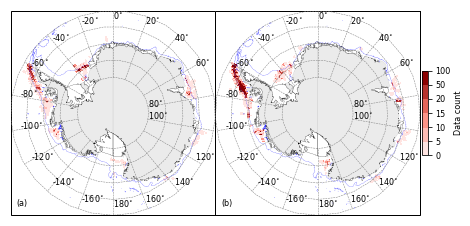

In [35]:
wd, ht = 190/25.4, 230/25.4
plt.figure(1, figsize=(wd,ht));
gs = gridspec.GridSpec(5, 4, height_ratios=[1]*5, width_ratios=[1, 1, 0.01, 0.03], wspace=0.)


mapax = plt.subplot(gs[:,0], projection = ccrs.Orthographic(central_longitude=0, central_latitude=-90) )
dfsel = ~dfmg.CTEMP.isna() & ~gline_le_75km & sel_months(dfmg, [12,1,2]) & regions & sel_echodepth
levels = list(np.arange(0,20.1, 5)) + [50, 100]
CF1 = topView.plotDataDensity_NIS_DIS(dfmg[dfsel], dfmg[~dfsel], wd=5.8, ht = 5, levels=levels, save=False,
                               mapax=mapax, subplotlabel="(a)", dx=0.5, dy=0.5)

mapax2 = plt.subplot(gs[:,1], projection = ccrs.Orthographic(central_longitude=0, central_latitude=-90) )
dfsel = ~dfmg.CTEMP.isna() & ~gline_le_75km & sel_months(dfmg, [7,8,9]) & regions & sel_echodepth
CF2 = topView.plotDataDensity_NIS_DIS(dfmg[dfsel], dfmg[~dfsel], wd=5.8, ht = 5, levels=levels, save=False,
                               mapax=mapax2, subplotlabel="(b)", dx=0.5, dy=0.5)

colorbarax = plt.subplot(gs[2, 3])
cbar1 = Colorbar(ax = colorbarax, mappable = CF1, ticks=levels, orientation='vertical') 
cbar1.ax.set_ylabel("Data count")
plt.savefig("./Images/dataDensity/DIS_DJF_JAS.jpg", dpi=600, bbox_inches = "tight")
plt.show()

In [48]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

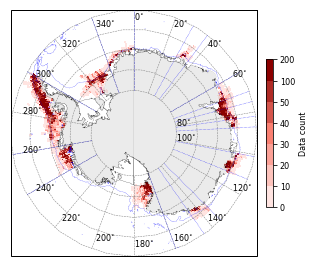

In [49]:
wd=190*0.65/25.4 
ht= 230*0.5 / 25.4
plt.figure(1, figsize=(wd,ht));
gs = gridspec.GridSpec(5, 2, height_ratios=[1]*5, width_ratios=[1, 0.025], wspace=0, hspace=0)

region_lons = [-120, -100, -60, -20, 0, 29, 37, 60, 70, 75, 82, 87, 101, 112, 135, 145, 160, 180]

mapax = plt.subplot(gs[:, 0], projection = ccrs.Orthographic(central_longitude=0, central_latitude=-90) )

levels = list(np.arange(0,51, 10) ) + [100, 200]
regions = Weddell + PrincessMartha + Harald + CDP + WPB + EPB + LAC + Knox + Adelie + Ross + Amundsen + BS
dfsel = regions & sel_echodepth
CF1 = topView.plotDataDensity_NIS_DIS(dfmg[dfsel], dfmg, wd=5.8, ht = 5, levels=levels, save=False, dx=0.5, dy=0.5,
                               savename = "./Images/dataDensity/dataDensity.jpg", mapax=mapax, subplotlabel=None,
                                     region_lons= region_lons)

colorbarax = plt.subplot(gs[1:4, 1])
cbar = Colorbar(ax = colorbarax, mappable = CF1, ticks=levels, orientation='vertical')
cbar.ax.set_ylabel("Data count")

plt.savefig("./Images/dataDensity/dataDensity_360.pdf", dpi=600, bbox_inches="tight")
plt.show()

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)


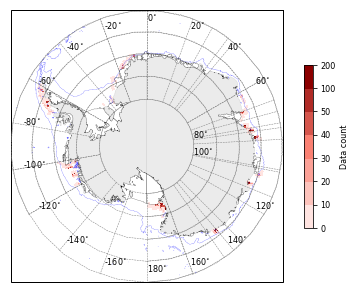

In [38]:

levels = list(np.arange(0,51, 10) ) + [100, 200]
regions = Weddell + PrincessMartha + Harald + CDP + WPB + EPB + LAC + Knox + Adelie + Ross + Amundsen + BS
months_seasons = [[12,1,2], [3,4,5], [6,7,8], [9,10,11]]
season_names = ['DJF', 'MAM', "JJA", "SON"]
for i in range(4):
    dfsel = regions & sel_echodepth & gline_le_75km & sel_months(dfmg, months_seasons[i])
    wd=5.8 
    ht=5
    plt.close(1)
    plt.figure(1, figsize=(wd,ht));
    gs = gridspec.GridSpec(5, 2, height_ratios=[1]*5, width_ratios=[1, 0.03], wspace=0, hspace=0)

    region_lons = [-120, -100, -60, -20, 0, 29, 37, 60, 70, 75, 82, 87, 101, 112, 135, 145, 160, 180]

    mapax = plt.subplot(gs[:, 0], projection = ccrs.Orthographic(central_longitude=0, central_latitude=-90) )

    CF1 = topView.plotDataDensity_NIS_DIS(dfmg[dfsel], dfmg, wd=5.8, ht = 5, levels=levels, dx=0.5, dy=0.5,
                               mapax=mapax,subplotlabel=None, region_lons= region_lons)

    colorbarax = plt.subplot(gs[1:4, 1])
    cbar = Colorbar(ax = colorbarax, mappable = CF1, ticks=levels, orientation='vertical')
    cbar.ax.set_ylabel("Data count")

    plt.savefig("./Images/dataDensity/NIS_"+season_names[i]+".jpg", dpi=600, bbox_inches="tight")

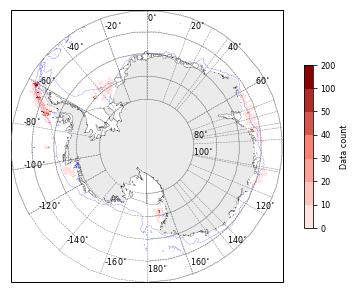

In [39]:

levels = list(np.arange(0,51, 10) ) + [100, 200]
regions = Weddell + PrincessMartha + Harald + CDP + WPB + EPB + LAC + Knox + Adelie + Ross + Amundsen + BS
months_seasons = [[12,1,2], [3,4,5], [6,7,8], [9,10,11]]
season_names = ['DJF', 'MAM', "JJA", "SON"]
for i in range(4):
    dfsel = regions & sel_echodepth & ~gline_le_75km & sel_months(dfmg, months_seasons[i])
    wd=5.8 
    ht=5
    plt.close(1)
    plt.figure(1, figsize=(wd,ht));
    gs = gridspec.GridSpec(5, 2, height_ratios=[1]*5, width_ratios=[1, 0.03], wspace=0, hspace=0)

    region_lons = [-120, -100, -60, -20, 0, 29, 37, 60, 70, 75, 82, 87, 101, 112, 135, 145, 160, 180]

    mapax = plt.subplot(gs[:, 0], projection = ccrs.Orthographic(central_longitude=0, central_latitude=-90) )

    CF1 = topView.plotDataDensity_NIS_DIS(dfmg[dfsel], dfmg, wd=5.8, ht = 5, levels=levels, dx=0.5, dy=0.5,
                               mapax=mapax,subplotlabel=None, region_lons= region_lons)

    colorbarax = plt.subplot(gs[1:4, 1])
    cbar = Colorbar(ax = colorbarax, mappable = CF1, ticks=levels, orientation='vertical')
    cbar.ax.set_ylabel("Data count")

    plt.savefig("./Images/dataDensity/DIS_"+season_names[i]+".jpg", dpi=600, bbox_inches="tight")

In [424]:
dfsel = CDW & sel_months(dfmg, [9]) & gline_le_50km & ~dfmg.CTEMP.isna() & BS
dod = dfmg[dfsel].DEPTH.min()
dfmg.loc[dfsel].groupby(pd.cut(dfmg[dfsel].DEPTH, np.arange(dod, 0.1, 20) ) ).CTEMP.count()

DEPTH
(-518.205, -498.205]    0
(-498.205, -478.205]    1
(-478.205, -458.205]    3
(-458.205, -438.205]    0
(-438.205, -418.205]    1
(-418.205, -398.205]    1
(-398.205, -378.205]    5
(-378.205, -358.205]    1
(-358.205, -338.205]    3
(-338.205, -318.205]    1
(-318.205, -298.205]    2
(-298.205, -278.205]    9
(-278.205, -258.205]    2
(-258.205, -238.205]    2
(-238.205, -218.205]    4
(-218.205, -198.205]    1
(-198.205, -178.205]    3
(-178.205, -158.205]    1
(-158.205, -138.205]    0
(-138.205, -118.205]    0
(-118.205, -98.205]     0
(-98.205, -78.205]      0
(-78.205, -58.205]      0
(-58.205, -38.205]      0
(-38.205, -18.205]      0
Name: CTEMP, dtype: int64

<IPython.core.display.Javascript object>


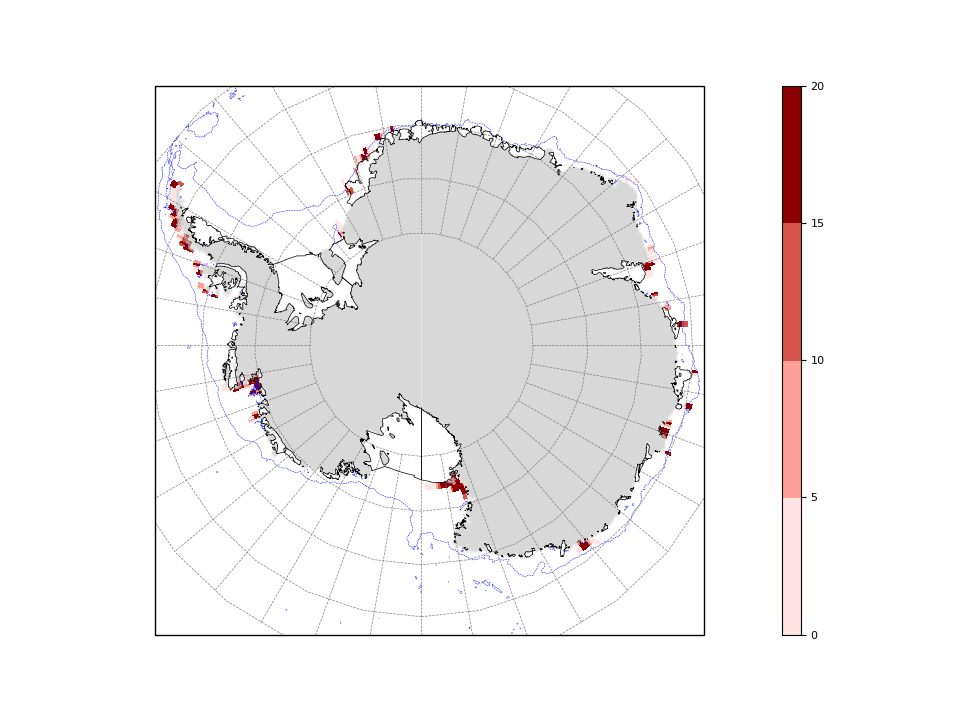

In [278]:
var = 'CTEMP'
dfsel = ~dfmg.CTEMP.isna() & gline_le_25km & sel_months(dfmg, [6,7,8,9,10,11])

levels = np.arange(0,20.1, 5)

topView.plotDataDensity_NIS_DIS(dfmg[dfsel], dfmg[~dfsel], wd=5.8, ht = 5, levels=levels, )

<IPython.core.display.Javascript object>


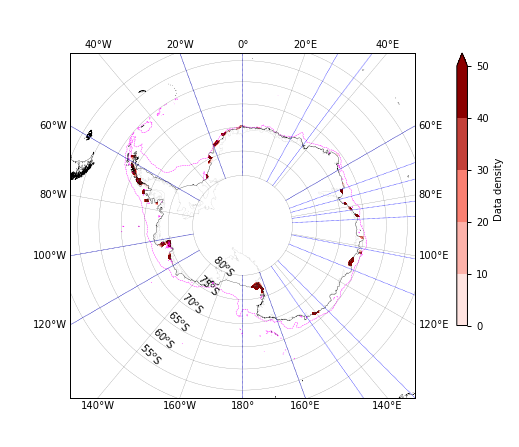

In [215]:
var = 'CTEMP'
dfsel = ~dfmg.CTEMP.isna() & gline_le_25km & sel_months(dfmg, [12,1,2,3,4,5])
levels = np.arange(0,51,10)
topView.plotDataDensity(dfmg[dfsel], wd=5.8, ht=5, levels=levels, cx=50, cy=50,
                        save=True, savename="./Images/dataDensity/dataDensity_NIS_DJF.png", show=True, 
                        plotBathy=True, 
                        fontsize=8)

In [12]:
slopeLonLatLims = np.array([ [-50.,-25., -75, -71] , [-25, -5, -80, -65], [-5, 0, -85, -67.6], 
                            [0,8, -85, -67.6], [8,46.9832, -80, -60], [46.9832, 48.3, -66.7, -60],
                            [48.3, 49.118, -80, -60], [49.118, 50.139, -66.455, -60], [50.139, 57.4, -80, -60],
                            [57.4, 58.9, -66.47, -60],[58.9, 59.68, -66.7, -60], [59.68, 60, -80, -60],
                            [60, 61.5, -66.85, -60], [61.5, 64, -80, -60], [64, 66, -67.1, -60],
                            [66, 79.4, -67.5, -63.5], [79.4, 81.5, -66.7, -64], [81.5, 89.68, -80, -64],
                            [89.68, 92.5, -65.8, -60], [92.5, 92.7, -80, -60], [92.7, 101, -65.1, -60],
                            [101, 103, -65, -60], [103, 105, -80, -60], [105, 109.5, -65.5, -60],
                            [109.5, 113, -65.9, -60], [113, 115, -65.47, -60], [115, 122, -80, -60], 
                            [122, 126, -66, -60], [126, 134, -65.3, -63], [134, 135, -65, -63],
                            [135, 148.6, -66.25, -63], [148.6, 152, -80, -65], [152, 155, -80, -65.5],
                            [155, 160, -80, -66], [160, 170, -73, -68.5], [170, 180, -73.6, -68.5],
                            [-180, -170, -80, -70], [-170, -160, -80, -73],
                            [-160, -151.3, -76.6, -73], [-151.3, -148.7, -76, -73], [-148.7, -140, -80, -73],
                            [-140, -136, -74.38, -71], [-136, -132, -74.3, -71], [-132, -130, -73.9, -71],
                            [-130, -120, -73.26, -70], [-120, -110, -72.8, -70], [-110, -100, -72, -70],
                            [-100, -90, -71.6, -69.3], [-90, -80, -71, -67.8], [-80, -75, -69.5, -65],
                            [-75, -72, -68.4, -65], [-72, -70, -67.6, -65], [-70, -68, -66.2, -63],
                            [-68, -66, -65, -63], [-66, -64, -64, -62.7], [-64, -62.37, -63.1, -61.86],
                            [-62.37, -62, -62.7, -61.86], [-62, -60, -62.55, -61], [-60, -58, -62, -60.8],
                            [-58, -56, -61.5, -60.6],
                            [-56, -50, -80, -60]] )

In [15]:
bathyS

<xarray.Dataset>
Dimensions:              (lat: 3600, lon: 8641)
Coordinates:
  * lon                  (lon) float64 -180.0 -180.0 -179.9 ... 180.0 180.0
  * lat                  (lat) float64 -90.0 -89.99 -89.98 ... -60.01 -60.0
Data variables:
    elevation            (lat, lon) float32 ...
    bathy_gradient       (lat, lon) float32 ...
    bathy_gradient_mask  (lat, lon) bool ...
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO_2014 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The bathymetric portion of the GEBCO_2014 Grid was largely ...
    history:      This is version 20150318 of the data set. Information on th...
    references:   Information on the data set is available from the GEBCO pro...
    comment:      The data in the GEBCO_2014 Grid should not be used for navi...
    node_offset:  1

In [16]:
#slopeLonLatLims[:, 0:2][slopeLonLatLims[:, 0:2] < 0] = slopeLonLatLims[:, 0:2][slopeLonLatLims[:, 0:2] < 0] + 360
#slopeLonLatLims[2][1] = 360

slopeMask = np.zeros(bathyS.elevation.shape, dtype=bool)
for i in range(len(slopeLonLatLims)):
    slopeMask = slopeMask + ~np.isnan(bathyS.elevation.where\
                                        (bathyS.lon >= slopeLonLatLims[i][0]).where\
                                        (bathyS.lon <= slopeLonLatLims[i][1]).where\
                                        (bathyS.lat >= slopeLonLatLims[i][2]).where\
                                        (bathyS.lat <= slopeLonLatLims[i][3]).values)

bathyGradMask = bathyS.bathy_gradient_mask.values
#del(bathyS)


In [17]:
#region1 : all COLD regime regions, color them BLUE
region1LonLims = [ [-40.,-20.] ,  [60,70], [70,75], 
                  [75,82], [135,145], [170,180]]
region1LatLims = [ [-77., -72], [-68., -66.47], [-69.75, -66.35],
                   [-69.75, -65.215], [-67.25, -65.4], [-78., -70]]
titles1 = ["WS", "CD", "WPB",        
           "EPB","AC", "RS"] 


region2LonLims = [ [-20., 0.] ,   [82,87], [101,112], ]
region2LatLims = [ [-72.5, -69],  [-67., -65.56], [-67., -64.5], ]
titles2 = ["PMC",  "LAC", "KC"]

region3LonLims = [[29,37], [-120,-100], [-100,-60]]
region3LatLims = [[-70.5, -65.38], [-75.25, -70.7], [-74., -61.4] ]
titles3 = ["PHC", "AS", "BS"]

regionsLonlim = [region1LonLims, region2LonLims, region3LonLims]
regionsLatlim = [region1LatLims, region2LatLims, region3LatLims]

#plt.figure(1, figsize=(10, 10) )
#mapax = plt.subplot(projection = ccrs.Orthographic(central_latitude=-90, central_longitude=0) )
#for i in range(len(regionsLonlim) ):
    

In [28]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

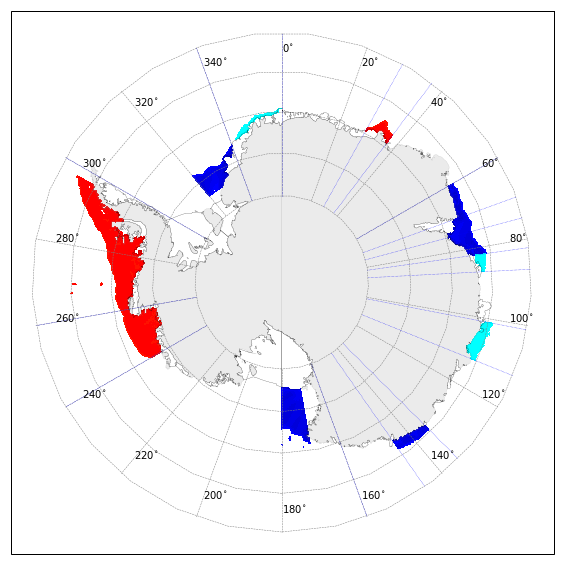

In [44]:
DATADIR = "/media/data"
#region1 : all COLD regime regions, color them BLUE
region1LonLims = [ [-40.,-20.] ,  [60,70], [70,75], 
                  [75,82], [135,145], [170,180]]
region1LatLims = [ [-77., -72], [-68., -66.47], [-69.75, -66.35],
                   [-69.75, -65.215], [-67.25, -65.4], [-78., -70]]
titles1 = ["WS", "CD", "WPB",        
           "EPB","AC", "RS"] 


region2LonLims = [ [-20., 0.] ,   [82,87], [101,112], ]
region2LatLims = [ [-72.5, -69],  [-67., -65.56], [-67., -64.5], ]
titles2 = ["PMC",  "LAC", "KC"]

region3LonLims = [[29,37], [-120,-100], [-100,-62.5]]
region3LatLims = [[-70.5, -65.38], [-75.25, -70.7], [-74., -61.4] ]
titles3 = ["PHC", "AS", "BS"]

regionsLonlim = [region1LonLims, region2LonLims, region3LonLims]
regionsLatlim = [region1LatLims, region2LatLims, region3LatLims]

wd= 10 #190*0.65/25.4 
ht= 10 #230*0.5 / 25.4
plt.figure(1, figsize=(wd, ht) )
mapax = plt.subplot(projection = ccrs.Orthographic(central_latitude=-90, central_longitude=0) )

gl = mapax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, zorder=2,
              linewidth=0.5, color='gray', alpha=1, linestyle='--')

gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-80, -59, 5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

region_lons = [-120, -100, -60, -20, 0, 29, 37, 60, 70, 75, 82, 87, 101, 112, 135, 145, 160, 180]
gl_regions = mapax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='blue', alpha=1, 
                             linestyle=':', zorder=3)
#gl_regions_lowZ = mapax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='blue', alpha=1, linestyle='--', zorder=1)
gl_regions.xlocator = mticker.FixedLocator(region_lons)
gl_regions.ylocator = mticker.FixedLocator(np.arange(-80, -59, 5) )
gl_regions.xformatter = LONGITUDE_FORMATTER
gl_regions.yformatter = LATITUDE_FORMATTER
gl_regions.ylines = False

shpfile = DATADIR+"/Datasets/Shapefiles/AntarcticGroundingLine/GSHHS_f_L6.shp"
with fiona.open(shpfile) as records:
    geometries = [sgeom.shape(shp['geometry']) for shp in records]
ISedgefname = DATADIR+"/Datasets/Shapefiles/AntIceShelf/ne_10m_antarctic_ice_shelves_polys.shp"
ISe_feature = ShapelyFeature(Reader(ISedgefname).geometries(), 
                             ccrs.PlateCarree(), linewidth=0.2,
                             facecolor='none', 
                             edgecolor="k")

mapax.add_geometries(geometries, ccrs.PlateCarree(), edgecolor='0.25', facecolor='0.7',alpha=0.25, linewidth=0.2)
mapax.add_feature(ISe_feature, zorder=3)


shelf_sel = ~np.isnan(bathyS.where((bathyS.elevation < 0) & (bathyS.elevation > -1000) ).elevation.values)
#cmap = ['Blues', 'cool', 'Reds']
vmin = [-1000, -500, -2000]
vmax = [0, 1000, -500]
from matplotlib.colors import BoundaryNorm
#bnorm = BoundaryNorm(np.arange(), ncolors=5, clip=False)

cmap1 = LinearSegmentedColormap.from_list(name='linearCmap', colors=['blue', 'mediumblue'], N=5)
cmap2 = LinearSegmentedColormap.from_list(name='linearCmap', colors=['aqua', 'cyan'], N=5)
cmap3 = LinearSegmentedColormap.from_list(name='linearCmap', colors=['orangered', 'red'], N=5)
cmap = [cmap1, cmap2, cmap3]

for i in range(len(regionsLonlim) ):
    for j in range(len(regionsLonlim[i])):
        selected_bathyS = bathyS.where(shelf_sel).sel(lon = slice(regionsLonlim[i][j][0], regionsLonlim[i][j][1]), lat = slice(regionsLatlim[i][j][0], regionsLatlim[i][j][1]) )
        mapax.pcolormesh(selected_bathyS.lon, selected_bathyS.lat, selected_bathyS.elevation, vmin=vmin[i], vmax=vmax[i], cmap=cmap[i], transform = ccrs.PlateCarree())
        
for l in np.arange(0, 360, 20):
    if( (l == 80) or (l == 100) ):
        text_lat = -62.5
    else:
        text_lat  = -62.5
    mapax.text(l, text_lat, str(l)+"$^{\circ}$", transform=ccrs.PlateCarree() )    

mapax.set_extent([-180, 180, -90, -57], crs = ccrs.PlateCarree() )    
plt.savefig("./Images/dataDensity/shelfRegimes.jpg", dpi=600, bbox_inches = "tight")

<IPython.core.display.Javascript object>


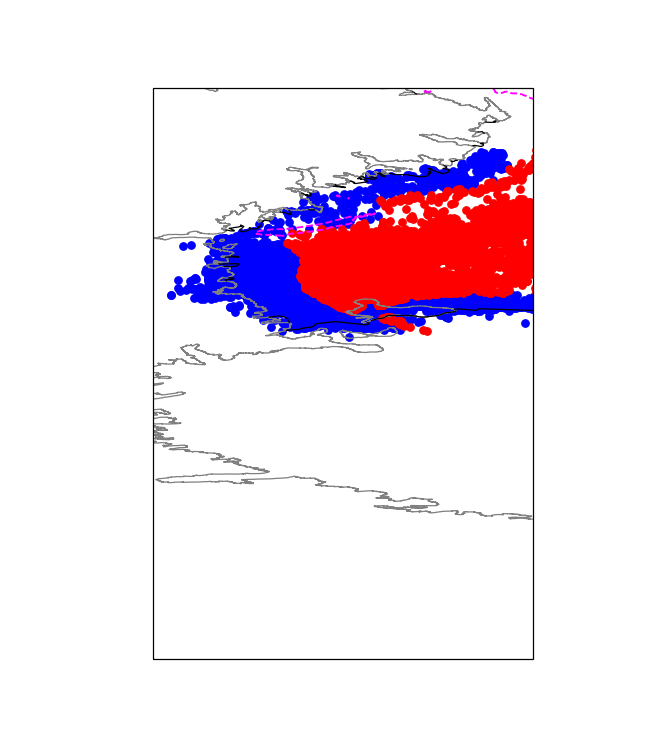

In [73]:
plot_NIS_DIS_profiles_single(dfmg, [True]*len(dfmg), months= np.arange(1,13), 
                             lonlatlims=[160, 180, -90, -60])

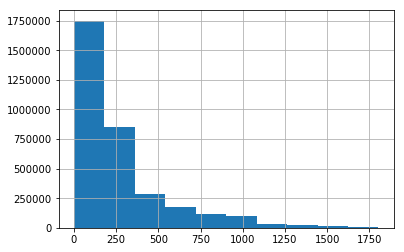

In [20]:
dfmg.DIST_GLINE.hist()

In [20]:
from haversine import haversine

In [21]:
haversine((-78.123103, -39.402174), (-77.844125, -39.418116))

31.0231760394528

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import mplcursors
np.random.seed(42)

ax = plt.subplot()
ax.scatter(*np.random.random((2, 26)))
ax.set_title("Mouse over a point")

mplcursors.cursor(hover=True)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/matplotlib/backends/web_backend/mpl.js'

In [21]:
topView.plotProfileNumberContours(dfmg, save=True, savename="./Images/profileContours.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()


819.0 819.0


/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:702: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Xgrid = np.linspace(m.llcrnrx, m.urcrnrx, nx)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:703: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Ygrid = np.linspace(m.llcrnry, m.urcrnry, ny)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3572: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/base

ValueError: operands could not be broadcast together with shapes (199169,) (819,819) 

In [10]:
A1 = gline_le_75km
A2 = ~gline_le_75km

regions1 = [Weddell & A1, CDP & A1,    EPB & A1,   
            Weddell & A2, CDP & A2,    EPB & A2,   
            WPB & A1,     Adelie & A1, Ross & A1, 
            WPB & A2,     Adelie & A2, Ross & A2]

titles1 = ["(a) WSA1", "(b) CDA1", "(c) EPBA1",        
          "(d) WSA2", "(e) CDA2", "(f) EPBA2", 
          "(g) WPBA1","(h) ACA1", "(i) RSA1",
          "(j) WPBA2","(k) ACA2", "(l) RSA2" ] 

regions2 = [PrincessMartha & A1, Harald & A1, (LAC ) & A1,
            PrincessMartha & A2, Harald & A2, (LAC ) & A2,
            Knox & A1,  Amundsen & A1, BS & A1, 
            Knox & A2, Amundsen & A2, BS & A2]

titles2 = ["(a) PMCA1", "(b) PHCA1", "(c) LACA1", 
           "(d) PMCA2", "(e) PHCA2", "(f) LACA2",
           "(g) KCA1", "(h) ASA1", "(i) BSA1", 
           "(j) KCA2", "(k) ASA2", "(l) BSA2"]

In [15]:
dfmg.columns

Index(['JULD', 'LATITUDE', 'LONGITUDE', 'PLATFORM_NUMBER', 'POSITION_QC',
       'PRES_ADJUSTED', 'PRES_ADJUSTED_ERROR', 'PRES_ADJUSTED_QC',
       'PROFILE_NUMBER', 'PSAL_ADJUSTED', 'PSAL_ADJUSTED_ERROR',
       'PSAL_ADJUSTED_QC', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_ERROR',
       'TEMP_ADJUSTED_QC', 'DEPTH', 'DENSITY_INSITU', 'POT_DENSITY', 'CTEMP',
       'SA', 'DIST_GLINE', 'ECHODEPTH', 'gamman'],
      dtype='object')

In [28]:
regions = regions1 + regions2
titles = titles1 + titles2
periodMonths = dfmg.JULD.dt.month.isin(np.arange(6,12,1))
indicesA1 = [0,1,2,6,7,8,12,13,14,18,19,20]
for i in indicesA1:
    nonull = ~dfmg.loc[:, 'DENSITY_INSITU'].isnull()
    nprofs = len(dfmg.loc[nonull & regions[i] & periodMonths, 'PROFILE_NUMBER']) #.unique()
    nprofsDSW = len(dfmg.loc[nonull & regions[i] & DSW & periodMonths, 'PROFILE_NUMBER']) #.unique()
    if(nprofsDSW/nprofs*1e2 > 5 ):
        DSWproducing = 'Yes'
    else:
        DSWproducing = 'No'
    print(titles[i].split()[1], nprofs, nprofsDSW, nprofsDSW/nprofs*1e2, DSWproducing)

WSA1 1727 922 53.38737695425594 Yes
CDA1 2131 1295 60.769591740966675 Yes
EPBA1 6374 1032 16.190775023533103 Yes
WPBA1 13276 10128 76.28803856583308 Yes
ACA1 23342 8082 34.6242824093908 Yes
RSA1 57514 43420 75.49466216921098 Yes
PMCA1 6987 0 0.0 No
PHCA1 944 0 0.0 No
LACA1 8238 1 0.012138868657441126 No
KCA1 9598 98 1.0210460512606794 No
ASA1 32293 0 0.0 No
BSA1 66209 0 0.0 No


In [45]:
indicesA1 = [0,1,2,6,7,8]
not_surface_water = (dfmg.DEPTH < -200)
nonull = ~dfmg.DENSITY_INSITU.isnull()
for i in indicesA1:
    print(titles1[i].split()[1], dfmg.loc[nonull & ~gt12CT & regions1[i] & not_surface_water, 'CTEMP'].max()) #quantile(0.99)

WSA1 -0.876169453487
CDA1 -0.488288070152
EPBA1 -0.481313088824
WPBA1 -0.613607900853
ACA1 -0.756519903604
RSA1 -0.319391336863


In [41]:
gt12CT = dfmg.CTEMP > 12
dfmg[gt12CT]

,JULD,LATITUDE,LONGITUDE,PLATFORM_NUMBER,POSITION_QC,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PROFILE_NUMBER,PSAL_ADJUSTED,...,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,DEPTH,DENSITY_INSITU,POT_DENSITY,CTEMP,SA,DIST_GLINE,ECHODEPTH,gamman
2352675,2006-03-24 04:10:00,-71.5150,-84.3992,b'00009654',b'1',570.0,NaN,1,372437,38.695473,...,0.20,1,-563.403697,1030.314500,27.871371,18.819751,38.885271,226.145244,-597.0,27.914545
2358337,2006-02-12 17:40:00,-62.7895,-61.8783,b'00010578',b'1',6.0,NaN,1,372723,10.904589,...,0.20,1,-5.942065,1007.753688,7.726057,14.003801,10.957031,147.994398,-172.0,2.822411
2358338,2006-02-12 17:40:00,-62.7895,-61.8783,b'00010578',b'1',14.0,NaN,1,372723,10.861481,...,0.20,1,-13.864548,1007.790597,7.726061,13.783898,10.913692,147.994398,-172.0,2.796150
2358339,2006-02-12 17:40:00,-62.7895,-61.8783,b'00010578',b'1',20.0,NaN,1,372723,10.563998,...,0.20,1,-19.806209,1007.817910,7.724958,12.157527,10.614754,147.994398,-172.0,2.795991
2358340,2006-02-12 17:40:00,-62.7895,-61.8783,b'00010578',b'1',24.0,NaN,1,372723,10.767167,...,0.20,1,-23.767220,1007.842193,7.731278,13.252706,10.818872,147.994398,-172.0,2.802608
2358341,2006-02-12 17:40:00,-62.7895,-61.8783,b'00010578',b'1',40.0,NaN,1,372723,10.727294,...,0.20,1,-39.610496,1007.916603,7.731574,13.034831,10.778815,147.994398,-172.0,2.802193
2358342,2006-02-12 17:40:00,-62.7895,-61.8783,b'00010578',b'1',50.0,NaN,1,372723,10.801184,...,0.20,1,-49.511918,1007.963991,7.733182,13.421031,10.853112,147.994398,-172.0,2.802977
2358344,2006-02-12 17:40:00,-62.7895,-61.8783,b'00010578',b'1',75.0,NaN,1,372723,10.604822,...,0.20,1,-74.263374,1008.079043,7.731038,12.350808,10.655901,147.994398,-172.0,2.800420
2358345,2006-02-12 17:40:00,-62.7895,-61.8783,b'00010578',b'1',100.0,NaN,1,372723,10.647182,...,0.20,1,-99.011831,1008.196721,7.733385,12.577433,10.698654,147.994398,-172.0,2.801361
2358346,2006-02-12 17:40:00,-62.7895,-61.8783,b'00010578',b'1',125.0,NaN,1,372723,10.842644,...,0.20,1,-123.757291,1008.315634,7.739613,13.596930,10.895179,147.994398,-172.0,2.805068


In [11]:
bathy

<xarray.Dataset>
Dimensions:    (lat: 21600, lon: 43200)
Coordinates:
  * lat        (lat) float64 -90.0 -89.99 -89.98 -89.97 -89.96 -89.95 -89.95 ...
  * lon        (lon) float64 -180.0 -180.0 -180.0 -180.0 -180.0 -180.0 ...
Data variables:
    elevation  (lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO_2014 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The bathymetric portion of the GEBCO_2014 Grid was largely ...
    history:      This is version 20150318 of the data set. Information on th...
    references:   Information on the data set is available from the GEBCO pro...
    comment:      The data in the GEBCO_2014 Grid should not be used for navi...
    node_offset:  1

In [12]:
bathy.sel()

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

In [8]:
mPrydz = topView.createMapProjections(-90, 0, region='Prydz')

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()


In [11]:
plt.close(1)
fig = plt.figure(1)
ax = plt.subplot()

mPrydz.contour(dfmg[CDP].LONGITUDE, dfmg[CDP].LATITUDE, dfmg[CDP].PROFILE_NUMBER, latlon=True, ax=ax)
plt.show()

SystemError: <class 'RuntimeError'> returned a result with an error set

In [11]:
var = 'PSAL_ADJUSTED'
dfno = dfmg.loc[~dfmg.loc[:, var].isnull()]
levels = [0, 10, 20, 30, 40, 50, 60, 100, 200, 500] #, 90, 150, 250, 500, 1000, 2500]
topView.plotDataDensity(dfno, wd=3, ht=2.6, levels=levels, cx=20, cy=20, region="Knox",
                        save=True, savename="./Images/dataDensity/Knox_dataDensity.png", show=True, plotBathy=True, 
                        fontsize=8)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:261: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Xgrid = np.linspace(m.llcrnrx, m.urcrnrx, nx)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:262: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Ygrid = np.linspace(m.llcrnry, m.urcrnry, ny)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.

ValueError: Image size of 9722155x5929863 pixels is too large. It must be less than 2^16 in each direction.

In [229]:
bathy = xr.open_dataset('/media/data/Datasets/Bathymetry/GEBCO_2014_2D.nc')

In [109]:
np.argmin(np.abs(bathy.lat - -60))

<xarray.DataArray 'lat' ()>
array(3600)

In [122]:
bathy.isel(lon=slice(0,-1)).lon.shape

(43199,)

In [123]:
bathy.isel(lat=slice(0,3600)).lat.shape

(3600,)

In [230]:
import importlib
importlib.reload(pltBathy)

<module 'plot_bathy' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_bathy.py'>

In [252]:
lonlen/180.

240.0

In [277]:
lonlen = len(bathy.lon)
lonindices = np.arange(0, lonlen+1, 60)
lonindices[-1] = lonindices[-1] - 1
bathyS = bathy.isel(lon=lonindices, lat=np.arange(0, 3600, 5))

In [278]:
bathyS.elevation.shape

(720, 721)

In [280]:
importlib.reload(pltBathy)

<module 'plot_bathy' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_bathy.py'>

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


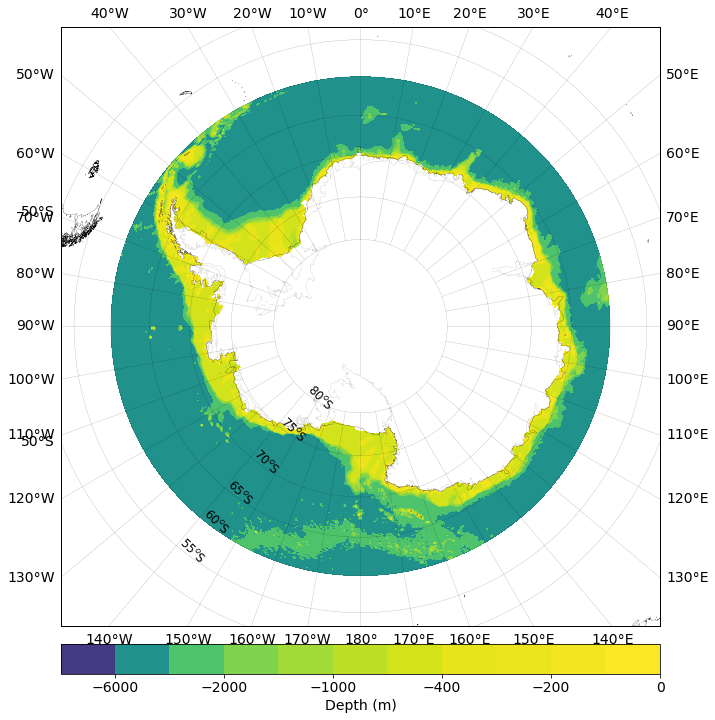

In [281]:
pltBathy.plot_bathy(bathyS, title='', wd=10, ht=10, save=True, 
                    savename="./Images/bathymetry.png", show=True)

<IPython.core.display.Javascript object>


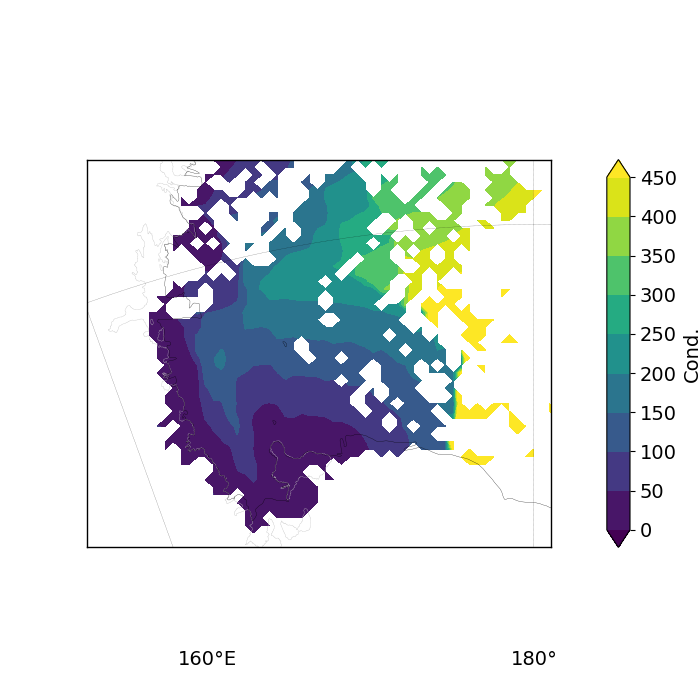

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()


134.0 134.0


/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:176: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Xgrid = np.linspace(m.llcrnrx, m.urcrnrx, nx)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:177: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Ygrid = np.linspace(m.llcrnry, m.urcrnry, ny)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [22]:
topView.plotSurfVarContourf(dfmg, var="DIST_GLINE", cmin=0, cmax=450, levels=[0,50,100,150,200,250,300,350,400, 450], 
                            region="Ross", nmin=0)

In [21]:
np.isnan([np.nan][0])

True

In [36]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()


409.0 409.0


/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:124: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Xgrid = np.linspace(m.llcrnrx, m.urcrnrx, nx)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:125: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Ygrid = np.linspace(m.llcrnry, m.urcrnry, ny)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:139: RuntimeWarning: invalid value encountered in true_divide
  #ni_masked = ma.masked_less(ni, nmin)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See

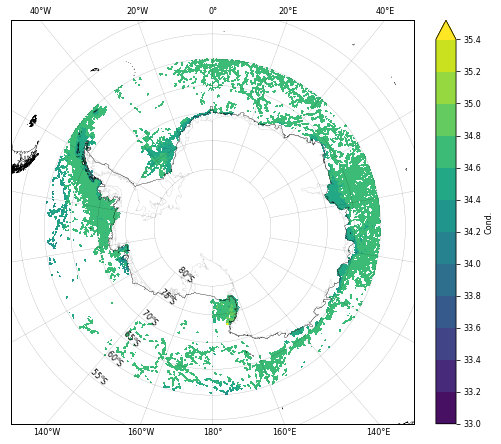

In [41]:
topView.plotBotVarContourf(dfmg, var="PSAL_ADJUSTED", save=True, savename="./Images/dataDensity/botSal.png", 
                           cx=20, cy=20)

In [12]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

409.0 409.0


/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:133: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Xgrid = np.linspace(m.llcrnrx, m.urcrnrx, nx)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:134: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Ygrid = np.linspace(m.llcrnry, m.urcrnry, ny)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:148: RuntimeWarning: invalid value encountered in true_divide
  zi[:, :] = zi[:, :]/ni[:, :]
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API 

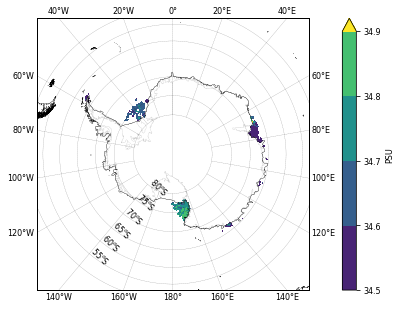

In [10]:
sourceProfiles = dfmg.PROFILE_NUMBER.isin(dfmg.loc[DSW, 'PROFILE_NUMBER'].unique())

topView.plotBotVarContourf(dfmg[sourceProfiles], var="PSAL_ADJUSTED", save=True, cmin=34.5, cmax=35.,
                           savename="./Images/dataDensity/botSal_Source.png", cx=20, wd=5.8, ht=5,
                           cy=20, levs=list(np.arange(34.5, 35., 0.1)))

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

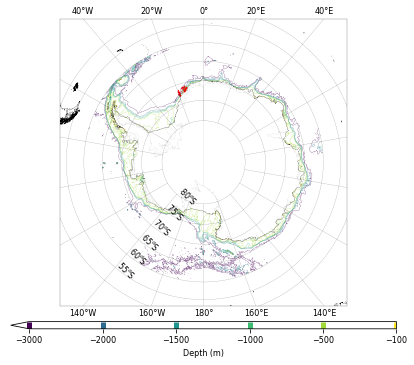

In [44]:
monthSel = (dfmg.JULD.dt.month >6) & (dfmg.JULD.dt.month < 11)

PMCA2JulyOctPos = dfmg.loc[PrincessMartha & ~gline_le_75km & monthSel, "LATITUDE": "LONGITUDE"].\
                        drop_duplicates(subset=['LONGITUDE', 'LATITUDE']).values
topView.plot_station_locations(PMCA2JulyOctPos, title='', wd=5.8, ht=5, 
                              save=True, savename="./Images/dataDensity/PMCA2JulyOctPos.png")

In [ ]:
PMC_CDWPos = dfmg.loc[PrincessMartha & ~gline_le_75km & monthSel, "LATITUDE": "LONGITUDE"].\
                        drop_duplicates(subset=['LONGITUDE', 'LATITUDE']).values
topView.plot_station_locations(PMCA2JulyOctPos, title='', wd=5.8, ht=5, 
                              save=True, savename="./Images/dataDensity/PMCA2JulyOctPos.png")

In [47]:
KC_DSW_Pos = dfmg.loc[Knox & WSO_source & gline_le_75km, "LATITUDE": "LONGITUDE"].\
                        drop_duplicates(subset=['LONGITUDE', 'LATITUDE']).values
topView.plot_station_locations(KC_DSW_Pos, title='', wd=5.8, ht=5, region="Knox",
                              save=True, savename="./Images/dataDensity/KC_DSW_Pos_A1.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 9722195x5929870 pixels is too large. It must be less than 2^16 in each direction.

In [59]:
Adelie_mCDW_Pos = dfmg.loc[Adelie & mCDW & gline_le_75km, "LATITUDE": "LONGITUDE"].\
                        drop_duplicates(subset=['LONGITUDE', 'LATITUDE']).values
topView.plot_station_locations(Adelie_mCDW_Pos, title='', wd=5.8, ht=5, region="Adelie",
                              save=True, savename="./Images/dataDensity/Adelie_mCDW_Pos_A1.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 9969722x7005558 pixels is too large. It must be less than 2^16 in each direction.

In [58]:
CD_mCDW_Pos = dfmg.loc[CDP & mCDW & gline_le_75km, "LATITUDE": "LONGITUDE"].\
                        drop_duplicates(subset=['LONGITUDE', 'LATITUDE']).values
topView.plot_station_locations(CD_mCDW_Pos, title='', wd=5.8, ht=5, region="Prydz",
                              save=True, savename="./Images/dataDensity/CD_mCDW_Pos_A1.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 8466978x5464766 pixels is too large. It must be less than 2^16 in each direction.

In [48]:
KC_DSW_Pos = dfmg.loc[Knox & WSO_source & ~gline_le_75km, "LATITUDE": "LONGITUDE"].\
                        drop_duplicates(subset=['LONGITUDE', 'LATITUDE']).values
topView.plot_station_locations(KC_DSW_Pos, title='', wd=5.8, ht=5, region="Knox",
                              save=True, savename="./Images/dataDensity/KC_DSW_Pos_A2.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 9722195x5929870 pixels is too large. It must be less than 2^16 in each direction.

In [57]:
for i in range(12):
    Adelie_Pos = dfmg.loc[Adelie & gline_le_75km & month_mask[i], "LATITUDE": "LONGITUDE"].\
                        drop_duplicates(subset=['LONGITUDE', 'LATITUDE']).values
    topView.plot_station_locations(Adelie_Pos, title='', wd=5.8, ht=5, region="Adelie",
                              save=True, savename="./Images/dataDensity/Adelie_"+month_names[i]+"_pos.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 9969722x7005558 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 9969722x7005558 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 9969722x7005558 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 9969722x7005558 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 9969722x7005558 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 9969722x7005558 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 9969722x7005558 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 9969722x7005558 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 9969722x7005558 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 9969722x7005558 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 9969722x7005558 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 9969722x7005558 pixels is too large. It must be less than 2^16 in each direction.

In [75]:
bathySouthern = bathy.isel(lat=slice(0,3000)).isel(lat=(np.arange(0,3000,5)), lon=(np.arange(0,43200, 100)))

In [295]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:514: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Xgrid = np.linspace(m.llcrnrx, m.urcrnrx, nx)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:515: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Ygrid = np.linspace(m.llcrnry, m.urcrnry, ny)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.

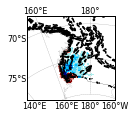

In [296]:
topView.plotDataDensity2layered(dfmg, (Ross & gline_le_75km), (Ross & ~gline_le_75km),
                                    levels=[1,5,10,20,30,50], show=True, region='Ross', save=True, 
                                savename="./Images/dataDensity/Ross_2layered.png", wd=2.4, ht=1.5, annotate=False)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:514: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:515: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  for i in range(len(xlons1)):
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated

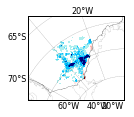

In [290]:
topView.plotDataDensity2layered(dfmg, (Weddell & gline_le_75km), (Weddell & ~gline_le_75km), annotate=False,
                                levels=[1,5,10,20,30,50], show=True, region='Weddell', save=True, wd=2.4, ht=1.5, 
                                savename="./Images/dataDensity/Weddell_2layered.png")

In [292]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:514: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Xgrid = np.linspace(m.llcrnrx, m.urcrnrx, nx)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:515: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Ygrid = np.linspace(m.llcrnry, m.urcrnry, ny)
/home/km/anaconda2/envs/py35new

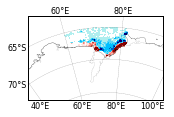

In [294]:
PBCD = Prydz + CDP
topView.plotDataDensity2layered(dfmg, (PBCD & gline_le_75km), (PBCD & ~gline_le_75km), wd=2.4, ht=1.5,
                                levels=[1,5,10,20,30,50], show=True, region='Prydz', save=True,  annotate=False,
                                savename="./Images/dataDensity/PrydzCD_2layered.png")

In [228]:
np.arange(0,10,0.5)[::4]

array([ 0.,  2.,  4.,  6.,  8.])

In [303]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

In [302]:
topView.plotDataDensity2layered(dfmg, (Adelie & gline_le_75km), (Adelie & ~gline_le_75km),
                                    levels=[1,5,10,20,30,50], show=True, region='Adelie', save=True, 
                                savename="./Images/dataDensity/Adelie_2layered.png", wd=3, ht=1)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:516: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Xgrid = np.linspace(m.llcrnrx, m.urcrnrx, nx)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:517: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Ygrid = np.linspace(m.llcrnry, m.urcrnry, ny)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.

ValueError: Image size of 9969701x7005633 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 9969725x7005572 pixels is too large. It must be less than 2^16 in each direction.

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:514: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:515: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  for i in range(len(xlons1)):
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated

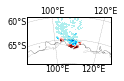

In [224]:
topView.plotDataDensity2layered(dfmg, (Knox & gline_le_75km), (Knox & ~gline_le_75km), annotate=False,
                                levels=[1,5,10,20,30,50], show=True, region='Knox', save=True,
                                savename="./Images/dataDensity/Knox_2layered.png", wd=3, ht=1)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:514: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:515: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  for i in range(len(xlons1)):
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated

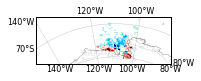

In [215]:
topView.plotDataDensity2layered(dfmg, (Amundsen & gline_le_75km), (Amundsen & ~gline_le_75km),
                                    levels=[1,5,10,20,30,50], show=True, region='Amundsen', save=True, 
                                savename="./Images/dataDensity/Amundsen_2layered.png", wd=3, ht=1, annotate=False)

In [307]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:516: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Xgrid = np.linspace(m.llcrnrx, m.urcrnrx, nx)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py:517: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  Ygrid = np.linspace(m.llcrnry, m.urcrnry, ny)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.

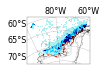

In [308]:
topView.plotDataDensity2layered(dfmg, (BS & gline_le_75km), (BS & ~gline_le_75km),
                                    levels=[1,5,10,20,30,50], show=True, region='Belingshausen', save=True, 
                                savename="./Images/dataDensity/Belingshausen_2layered.png", wd=3, ht=1, annotate=False)

In [319]:
func1(ax = ax)

In [323]:
ax.imshow()

TypeError: imshow() missing 1 required positional argument: 'X'

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


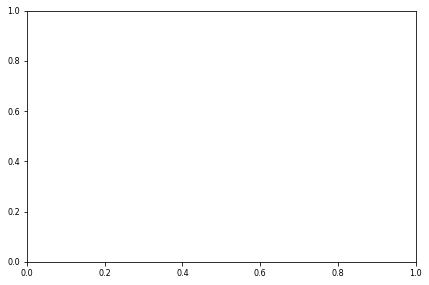

In [309]:
fig, ax = plt.subplots()

## Creating array of monthly count images

In [39]:
!mkdir ./Images/counts

In [24]:
def create_monthlyCount_array(dfmg, regions=[], titles=[], mrows=1, ncols=5, wd=7.48, ht=3, 
                              save=False, savename="untitled.png"):
    fig = plt.figure(figsize=(wd, ht))
    axarr = []
    counter = 0
    
    for i in range(mrows):
        for j in range(ncols):
            if counter > len(regions)-1:
                pass
            else:
                axarr.append(plt.subplot2grid((mrows, ncols), (i, j)  ))
                ax_sp = monthCount.plot_counts_profs(axarr[-1], dfmg, WSO_source, WSO_prod, 
                                                     regions[counter], titles[counter])
                if(j>0):
                    axarr[-1].set_yticklabels([])
                    axarr[-1].set_ylabel("")
                    axarr[-1].set_yticks([])
                if(j < ncols-1):
                    ax_sp.set_yticklabels([])
                counter += 1
            
        if counter > len(regions):
            break
    plt.tight_layout()
    fig.subplots_adjust(wspace=0)
    if(save == True):
        plt.savefig(savename, dpi=300)
    plt.show()

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_monthly_count.py:54: RuntimeWarning: invalid value encountered in true_divide
  rects_source = ax_sp.bar(np.arange(12)+wd, nprof_source/nprof_all*100, wd, color='r', label='source')
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_monthly_count.py:55: RuntimeWarning: invalid value encountered in true_divide
  rects_prod = ax_sp.bar(np.arange(12)+wd*2, nprof_prod/nprof_all*100, wd, color='b', label='prod')


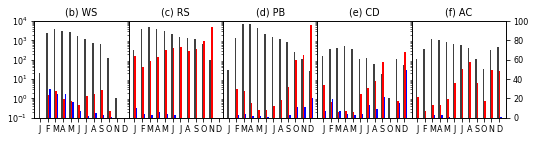

In [25]:
regions = [Weddell, Ross, Prydz, CDP, Adelie]
titles = ["(b) WS", "(c) RS", "(d) PB", "(e) CD", "(f) AC"]

create_monthlyCount_array(dfmg, regions=regions, titles=titles, save=True, savename="./Images/counts/counts.png", 
                          mrows=1, ncols=5, ht=2.)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


0 0


/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_monthly_count.py:61: RuntimeWarning: invalid value encountered in true_divide
  rects_source = ax_sp.bar(np.arange(12)+wd, nprof_source/nprof_all*100, wd, color='r', label='source')
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_monthly_count.py:62: RuntimeWarning: invalid value encountered in true_divide
  rects_prod = ax_sp.bar(np.arange(12)+wd*2, nprof_prod/nprof_all*100, wd, color='b', label='prod')


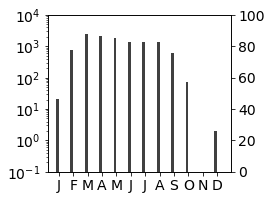

In [46]:
monthCount.plot_counts_profs(dfmg, WSO_source, WSO_prod, 
                             boxes=[AmundsenEast+AmundsenWest],
                             row=1, col=1, titles=[], ht=3, wd=4, save=True, savename="./Images/counts/Amundsen.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


0 0


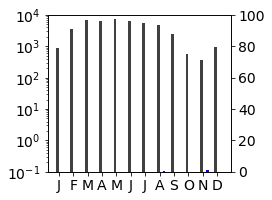

In [47]:
monthCount.plot_counts_profs(dfmg, WSO_source, WSO_prod, boxes=[WBS+EBS],
                             row=1, col=1, titles=[], ht=3, wd=4, save=True, savename="./Images/counts/BS.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


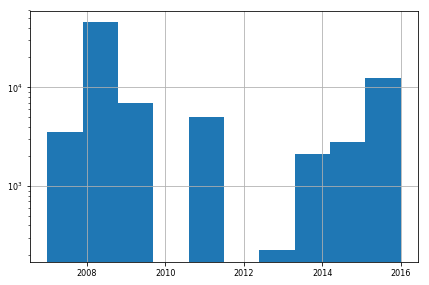

In [54]:
dfmg.loc[PrincessMartha, 'JULD'].dt.year.hist()   
plt.yscale("log")
plt.ylim()
plt.show()

## Years Sampled in each region

In [97]:
yearmask = dfmg.JULD.dt.year == 2014
dfmg.loc[Weddell & yearmask, "PSAL_ADJUSTED"].unique()

array([         nan,  34.04399872,  34.12841415, ...,  34.4613533 ,
        34.4666748 ,  34.47262192])

In [57]:
def plot_region_years_hist(region):
    years_sorted = np.sort(dfmg.loc[region, "JULD"].dt.year.unique())
    nprof = np.zeros(len(years_sorted))
    for i in range(len(years_sorted)):
        yearmask = dfmg.loc[region , "JULD"].dt.year.isin([years_sorted[i]])
        nprof[i] = len(dfmg.loc[region & yearmask, 'PROFILE_NUMBER'].unique())
    fig = plt.figure()
    plt.bar(years_sorted, nprof)
    plt.xticks(years_sorted, rotation=90)
    plt.yscale("log")
    plt.ylim(1e-1)
    plt.grid()
    plt.show()
    print(repr(years_sorted - 2000))

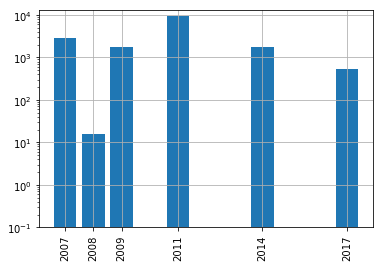

array([2007, 2008, 2009, 2011, 2014, 2017])


In [11]:
plot_region_years_hist(Weddell)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


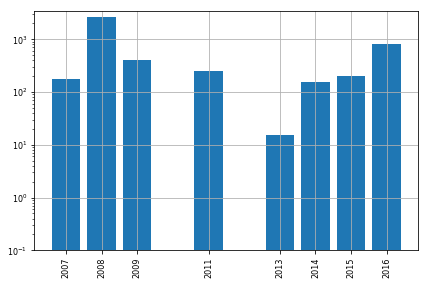

array([ 7,  8,  9, 11, 13, 14, 15, 16])


In [58]:
plot_region_years_hist(PrincessMartha)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


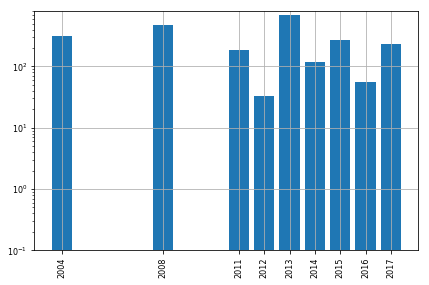

array([ 4,  8, 11, 12, 13, 14, 15, 16, 17])


In [60]:
plot_region_years_hist(Harald)

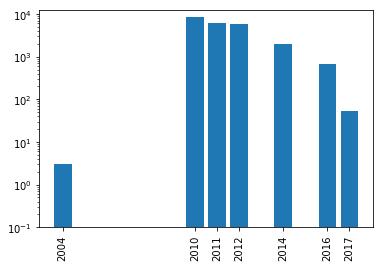

array([2004, 2010, 2011, 2012, 2014, 2016, 2017])


In [9]:
plot_region_years_hist(Ross)

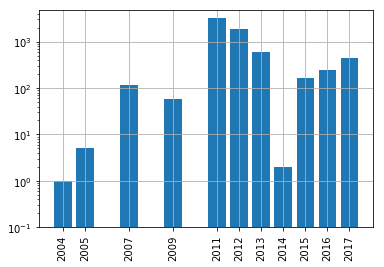

array([2004, 2005, 2007, 2009, 2011, 2012, 2013, 2014, 2015, 2016, 2017])


In [15]:
plot_region_years_hist(WPB)

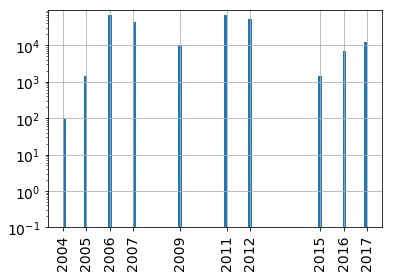

array([ 4,  5,  6,  7,  9, 11, 12, 15, 16, 17])


In [78]:
plot_region_years_hist(EPB)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


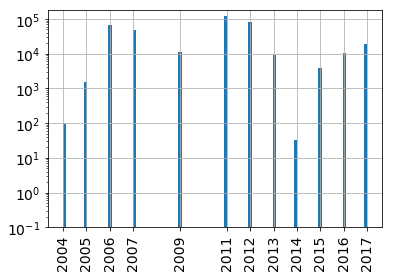

array([ 4,  5,  6,  7,  9, 11, 12, 13, 14, 15, 16, 17])


In [79]:
plot_region_years_hist(EPB+WPB)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


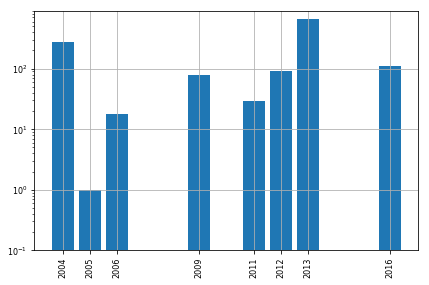

array([ 4,  5,  6,  9, 11, 12, 13, 16])


In [66]:
plot_region_years_hist(LAC)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


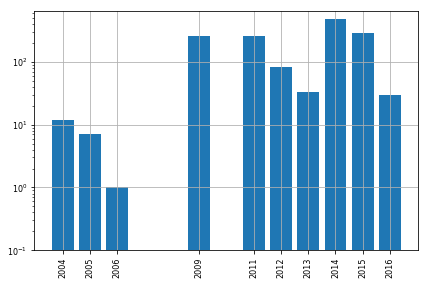

array([ 4,  5,  6,  9, 11, 12, 13, 14, 15, 16])


In [67]:
plot_region_years_hist(QMC)

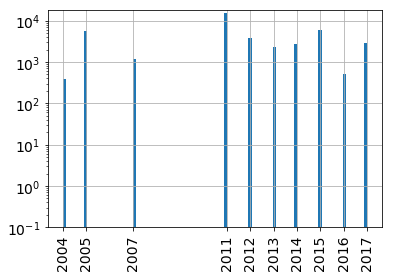

array([ 4,  5,  7, 11, 12, 13, 14, 15, 16, 17])


In [80]:
plot_region_years_hist(CDP)

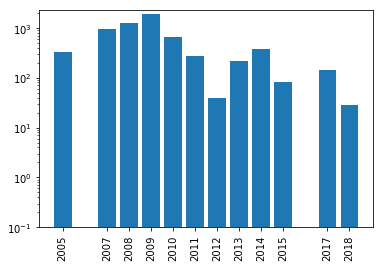

array([2005, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2017,
       2018])


In [98]:
plot_region_years_hist(Adelie)

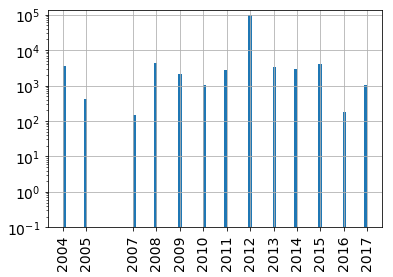

array([ 4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])


In [82]:
plot_region_years_hist(Knox)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


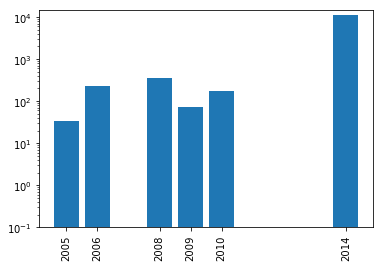

array([2005, 2006, 2008, 2009, 2010, 2014])


In [99]:
plot_region_years_hist(AmundsenEast+AmundsenWest)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


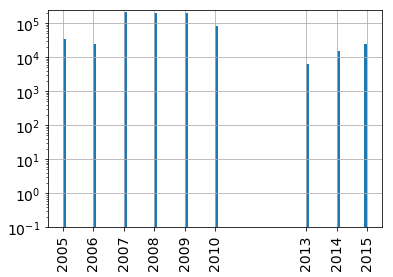

array([ 5,  6,  7,  8,  9, 10, 13, 14, 15])


In [84]:
plot_region_years_hist(EBS+WBS)

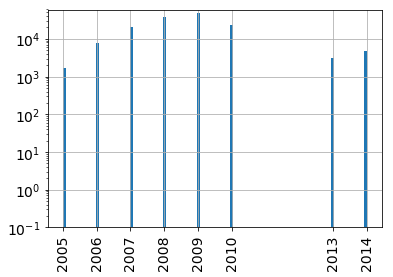

array([ 5,  6,  7,  8,  9, 10, 13, 14])


In [85]:
plot_region_years_hist(WBS)

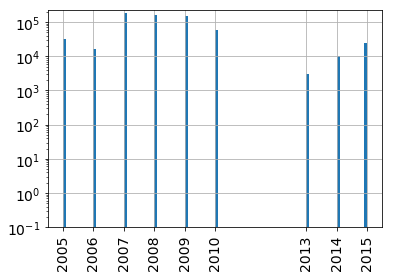

array([ 5,  6,  7,  8,  9, 10, 13, 14, 15])


In [86]:
plot_region_years_hist(EBS)

In [114]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35ne

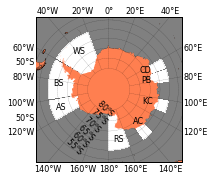

In [116]:
regionLonLims = [ [-59, -20], [60, 69], [71, 82], [101, 112], [135, 145], [160, 180], [-120, -101], [-99, -61] ]
regionNames = ["WS", "CD", "PB", "KC", "AC", "RS", "AS", "BS"]
regionNamesxy = [[-45, -65], [60, -73], [77, -74], [112, -72.5], [145, -70], [175, -65], [-110, -62.5], [-85, -62.5]]
topView.createShadedRegionPlot(regionLonLims= regionLonLims, regionNames=regionNames, regionNamesxy=regionNamesxy,
                               save=True, savename="./Images/dataDensity/regionShaded.png", wd=3., ht=2.36)

In [441]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

In [60]:
regionLonLims = [ [-59, -20], [60, 69], [71, 82], [101, 112], [135, 145], [160, 180], [-120, -101], [-99, -61], [-20,0] , 
                [29, 37], [82, 96.5]]
np.array(regionLonLims).ravel()

array([ -59. ,  -20. ,   60. ,   69. ,   71. ,   82. ,  101. ,  112. ,
        135. ,  145. ,  160. ,  180. , -120. , -101. ,  -99. ,  -61. ,
        -20. ,    0. ,   29. ,   37. ,   82. ,   96.5])

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35ne

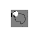

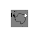

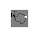

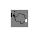

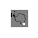

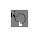

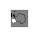

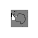

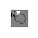

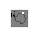

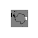

In [59]:
regionLonLims = [ [-59, -20], [60, 69], [71, 82], [101, 112], [135, 145], [160, 180], [-120, -101], [-99, -61], [-20,0] , 
                [29, 37], [82, 96.5]]
regionNames = ["WS", "CD", "PB", "KC", "AC", "RS", "AS", "BS", "PMC", "PHC", "West"]
for i in range(len(regionLonLims)):
    savename = "./Images/dataDensity/"+regionNames[i]+"_shaded.png"
    topView.createShadedRegionPlot(regionLonLims= [regionLonLims[i]], regionNames=[], regionNamesxy=[], annotate=False,
                               save=True, savename=savename, 
                               wd=0.86, ht=0.58, linewidth=0.5, dpi=900)

## CDW locations around Antarctica

Location of profiles detecting CDW

In [37]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

In [38]:
CDW = (dfmg.PSAL_ADJUSTED > 34.5) & (dfmg.CTEMP > 0)

In [39]:
CDWpositions = dfmg.loc[CDW, "LATITUDE": "LONGITUDE"].\
                        drop_duplicates(subset=['LONGITUDE', 'LATITUDE']).values

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

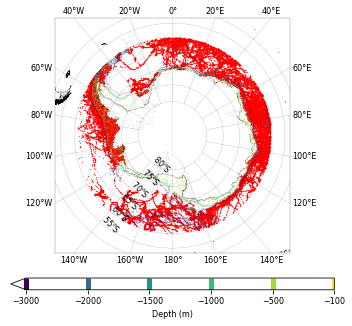

In [78]:
CDWpositions = dfmg.loc[CDW, "LATITUDE": "LONGITUDE"].\
                        drop_duplicates(subset=['LONGITUDE', 'LATITUDE']).values
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, 
                              save=True, savename="./Images/dataDensity/CDWpositions.png")

In [101]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Weddell",
                              save=True, savename="./Images/dataDensity/WS_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 5659861x5523520 pixels is too large. It must be less than 2^16 in each direction.

In [102]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Ross",
                              save=True, savename="./Images/dataDensity/RS_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 8719894x9170325 pixels is too large. It must be less than 2^16 in each direction.

In [42]:
topView.plot_station_locations(CDWpositions, title='', wd=3, ht=2.6, region="Knox", plotBathy=True,
                              save=True, savename="./Images/dataDensity/KC_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 9722182x5929885 pixels is too large. It must be less than 2^16 in each direction.

In [99]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Adelie",
                              save=True, savename="./Images/dataDensity/AC_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 9969746x7005558 pixels is too large. It must be less than 2^16 in each direction.

In [52]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

In [53]:
topView.plot_station_locations(CDWpositions, title='', wd=3, ht=2.6, region="Prydz",
                              save=True, savename="./Images/dataDensity/CD_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 8467006x5464788 pixels is too large. It must be less than 2^16 in each direction.

In [103]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Amundsen",
                              save=True, savename="./Images/dataDensity/AS_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 5817855x9535680 pixels is too large. It must be less than 2^16 in each direction.

In [104]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Belingshausen",
                              save=True, savename="./Images/dataDensity/BS_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 5368344x7915358 pixels is too large. It must be less than 2^16 in each direction.